In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.gridspec import GridSpec
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib.colors import LinearSegmentedColormap

# Set up paths for utility imports
current_dir = os.getcwd()
utilities_dir = os.path.join(current_dir, '../../utils')

# Change working directory
os.chdir(current_dir)
sys.path.insert(0, utilities_dir)

from plotting import *   

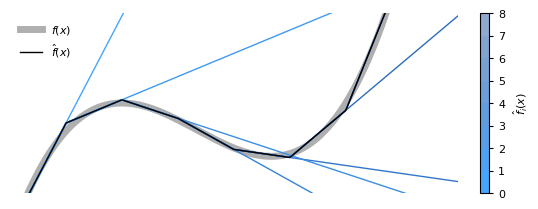

In [10]:

# ==== Datos ====
x_min, x_max = -2, 2
x = np.linspace(x_min, x_max, 400)
f = x**3 + x**2 - x - 1

device = torch.device("cpu")

x_tensor_full = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
f_tensor_full = torch.tensor(f, dtype=torch.float32).unsqueeze(1).to(device)

# ==== Modelo ====
class FixedBreakReLU(nn.Module):
    def __init__(self, fixed_break, activate_left=False, y_offset=0.0):
        super().__init__()
        self.register_buffer("x_star", torch.tensor([[fixed_break]], dtype=torch.float32))
        self.w = nn.Parameter(torch.tensor([[0.1]], dtype=torch.float32))
        self.y_offset = nn.Parameter(torch.tensor([[y_offset]], dtype=torch.float32))
        self.activate_left = activate_left

    def forward(self, x):
        if self.activate_left:
            z = torch.relu(self.x_star - x.T)
        else:
            z = torch.relu(x.T - self.x_star)
        out = (self.w.T @ z).T + self.y_offset
        return out, z

# ==== Lista de tramos automática con número definido de segmentos ====
num_segments = 8  # <-- define aquí cuántos segmentos quieres
segments = []

# Calcular tamaño de cada tramo
step = (x_max - x_min) / num_segments
curr = x_min
for i in range(num_segments):
    segments.append((curr, min(curr + step, x_max)))
    curr += step

# ==== Entrenamiento por tramo ====
y_accum = np.zeros_like(x)
prev_slope_accum = 0.0
all_contribs = []        # guardar contribuciones individuales
partial_accums = []      # guardar acumulados parciales

prev_y_at_right = 0.0

for i, (seg_left, seg_right) in enumerate(segments):
    mask_local = (x >= seg_left) & (x <= seg_right)
    x_local = x[mask_local]
    f_local = f[mask_local]
    x_tensor_local = torch.tensor(x_local, dtype=torch.float32).unsqueeze(1).to(device)
    f_tensor_local = torch.tensor(f_local, dtype=torch.float32).unsqueeze(1).to(device)

    offset_start = y_accum[np.argmin(np.abs(x - seg_left))]

    # ==== Configuración del break y offset ====
    if i == 0:
        fixed_break = seg_left
        activate_left = False
        model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=0.0).to(device)
        model.y_offset = nn.Parameter(torch.tensor([[0.0]], dtype=torch.float32).to(device))
        optimizer = optim.Adam([model.w, model.y_offset], lr=0.05)
    else:
        fixed_break = seg_left
        activate_left = False
        model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=offset_start).to(device)
        optimizer = optim.Adam([model.w], lr=0.05)

    loss_fn = nn.MSELoss()

    # ==== Entrenamiento ====
    for epoch in range(3000):
        optimizer.zero_grad()
        out_local, _ = model(x_tensor_local)
        target_corr = f_tensor_local - prev_slope_accum * (x_tensor_local - seg_left)
        loss = loss_fn(out_local, target_corr)
        loss.backward()
        optimizer.step()

    # ==== Evaluación ====
    with torch.no_grad():
        out_full, z_full = model(x_tensor_full)
        contrib = (model.w * z_full).squeeze().cpu().numpy()
        if i == 0:
            contrib += model.y_offset.item()

        all_contribs.append(contrib.copy())
        y_accum += contrib
        partial_accums.append(y_accum.copy())

        prev_slope_accum += model.w.item()
        prev_y_at_right = y_accum[np.argmin(np.abs(x - seg_right))]


#%% 
num_segments = len(partial_accums)

# Crear colormap de azul a gris
cmap_discrete = LinearSegmentedColormap.from_list('blue_gray', ["#45A5FF", "#2255a080"], N=num_segments)

fig, ax = plt.subplots(figsize=(5.4, 2.0), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.10, h_pad=0.05)

ax.plot(x, f, '-', color="#AFAFAF", linewidth=5, label=r'$f(x)$')

for i, partial in enumerate(reversed(partial_accums)):
    ax.plot(x, partial, color=cmap_discrete(1 - i/(num_segments-1)), lw=1.0, alpha=1.0)

# Línea negra final (aproximación completa)
ax.plot(x, partial_accums[-1], color='k', lw=1.0, label=r'$\hat{f}(x)$')  # <-- added line

ax.set_ylim([-2.0, 2.0])
ax.set_xlim([x_min, x_max])
ax.axis('off')

# ==== Colorbar ====
bounds = np.arange(0.0, num_segments + 1.0)  # ticks centrados en cada segmento
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=num_segments)

sm = mpl.cm.ScalarMappable(cmap=cmap_discrete, norm=norm)
sm.set_array([])

# Solo mostrar ticks enteros
cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(0, num_segments + 1))
cbar.set_label(r"$\hat{f}_{i}(x)$")

# ==== Legend ====
ax.legend(loc='upper left', fontsize=8, frameon=False)

plt.savefig("figs/plot_universal_approximation_demo.svg", dpi=300, bbox_inches='tight')
plt.show()

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family ['xkcd'] not found. Falling back to DejaVu Sans.


findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd' not found.


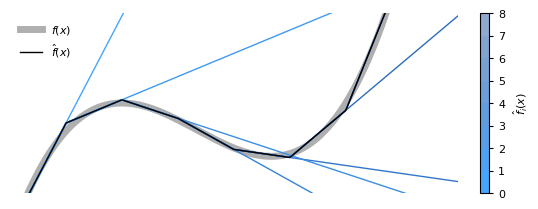

In [ ]:

# ==== Datos ====
x_min, x_max = -2, 2
x = np.linspace(x_min, x_max, 400)
f = x**3 + x**2 - x - 1

device = torch.device("cpu")

x_tensor_full = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
f_tensor_full = torch.tensor(f, dtype=torch.float32).unsqueeze(1).to(device)

# ==== Modelo ====
class FixedBreakReLU(nn.Module):
    def __init__(self, fixed_break, activate_left=False, y_offset=0.0):
        super().__init__()
        self.register_buffer("x_star", torch.tensor([[fixed_break]], dtype=torch.float32))
        self.w = nn.Parameter(torch.tensor([[0.1]], dtype=torch.float32))
        self.y_offset = nn.Parameter(torch.tensor([[y_offset]], dtype=torch.float32))
        self.activate_left = activate_left

    def forward(self, x):
        if self.activate_left:
            z = torch.relu(self.x_star - x.T)
        else:
            z = torch.relu(x.T - self.x_star)
        out = (self.w.T @ z).T + self.y_offset
        return out, z

# ==== Lista de tramos automática con número definido de segmentos ====
num_segments = 8  # <-- define aquí cuántos segmentos quieres
segments = []

# Calcular tamaño de cada tramo
step = (x_max - x_min) / num_segments
curr = x_min
for i in range(num_segments):
    segments.append((curr, min(curr + step, x_max)))
    curr += step

# ==== Entrenamiento por tramo ====
y_accum = np.zeros_like(x)
prev_slope_accum = 0.0
all_contribs = []        # guardar contribuciones individuales
partial_accums = []      # guardar acumulados parciales

prev_y_at_right = 0.0

for i, (seg_left, seg_right) in enumerate(segments):
    mask_local = (x >= seg_left) & (x <= seg_right)
    x_local = x[mask_local]
    f_local = f[mask_local]
    x_tensor_local = torch.tensor(x_local, dtype=torch.float32).unsqueeze(1).to(device)
    f_tensor_local = torch.tensor(f_local, dtype=torch.float32).unsqueeze(1).to(device)

    offset_start = y_accum[np.argmin(np.abs(x - seg_left))]

    # ==== Configuración del break y offset ====
    if i == 0:
        fixed_break = seg_left
        activate_left = False
        model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=0.0).to(device)
        model.y_offset = nn.Parameter(torch.tensor([[0.0]], dtype=torch.float32).to(device))
        optimizer = optim.Adam([model.w, model.y_offset], lr=0.05)
    else:
        fixed_break = seg_left
        activate_left = False
        model = FixedBreakReLU(fixed_break=fixed_break, activate_left=activate_left, y_offset=offset_start).to(device)
        optimizer = optim.Adam([model.w], lr=0.05)

    loss_fn = nn.MSELoss()

    # ==== Entrenamiento ====
    for epoch in range(3000):
        optimizer.zero_grad()
        out_local, _ = model(x_tensor_local)
        target_corr = f_tensor_local - prev_slope_accum * (x_tensor_local - seg_left)
        loss = loss_fn(out_local, target_corr)
        loss.backward()
        optimizer.step()

    # ==== Evaluación ====
    with torch.no_grad():
        out_full, z_full = model(x_tensor_full)
        contrib = (model.w * z_full).squeeze().cpu().numpy()
        if i == 0:
            contrib += model.y_offset.item()

        all_contribs.append(contrib.copy())
        y_accum += contrib
        partial_accums.append(y_accum.copy())

        prev_slope_accum += model.w.item()
        prev_y_at_right = y_accum[np.argmin(np.abs(x - seg_right))]


#%% 
num_segments = len(partial_accums)

# Crear colormap de azul a gris
cmap_discrete = LinearSegmentedColormap.from_list('blue_gray', ["#45A5FF", "#2255a080"], N=num_segments)

fig, ax = plt.subplots(figsize=(5.4, 2.0), constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=0.10, h_pad=0.05)

ax.plot(x, f, '-', color="#AFAFAF", linewidth=5, label=r'$f(x)$')

for i, partial in enumerate(reversed(partial_accums)):
    ax.plot(x, partial, color=cmap_discrete(1 - i/(num_segments-1)), lw=1.0, alpha=1.0)

# Línea negra final (aproximación completa)
ax.plot(x, partial_accums[-1], color='k', lw=1.0, label=r'$\hat{f}(x)$')  # <-- added line

ax.set_ylim([-2.0, 2.0])
ax.set_xlim([x_min, x_max])
ax.axis('off')

# ==== Colorbar ====
bounds = np.arange(0.0, num_segments + 1.0)  # ticks centrados en cada segmento
norm = mpl.colors.BoundaryNorm(boundaries=bounds, ncolors=num_segments)

sm = mpl.cm.ScalarMappable(cmap=cmap_discrete, norm=norm)
sm.set_array([])

# Solo mostrar ticks enteros
cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(0, num_segments + 1))
cbar.set_label(r"$\hat{f}_{i}(x)$")

# ==== Legend ====
ax.legend(loc='upper left', fontsize=8, frameon=False)

plt.savefig("figs/plot_universal_approximation_demo_xkcd.svg", dpi=300, bbox_inches='tight')
plt.show()